In [ ]:
# Install required packages
!pip install -q tensorflow matplotlib scikit-image tqdm opencv-python

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a directory for the project
!mkdir -p /content/drive/MyDrive/cell_segmentation

Mounted at /content/drive


In [ ]:
# Upload your dataset zip file
from google.colab import files
uploaded = files.upload()  # Select your processed.zip file


Saving processed.zip to processed.zip


In [ ]:
# Create directories
!mkdir -p /content/data

# Extract dataset
!unzip -q /content/processed.zip -d /content/data/

# Check what got extracted
!ls -la /content/data/

total 12
drwxr-xr-x  3 root root 4096 Apr  4 19:52 .
drwxr-xr-x  1 root root 4096 Apr  4 19:25 ..
drwxr-xr-x 10 root root 4096 Apr  4 19:52 bloodcells_dataset
-rw-r--r--  1 root root    0 Apr  4 19:15 bloodcells_dataset.zip


In [ ]:
# Verify the dataset structure
!ls -la /content/data/
!ls -la /content/data/bloodcells_dataset/
!ls -la /content/data/bloodcells_dataset/basophil/ | head -5  # Show just the first 5 files in basophil

total 12
drwxr-xr-x  3 root root 4096 Apr  4 19:52 .
drwxr-xr-x  1 root root 4096 Apr  4 19:25 ..
drwxr-xr-x 10 root root 4096 Apr  4 19:52 bloodcells_dataset
-rw-r--r--  1 root root    0 Apr  4 19:15 bloodcells_dataset.zip
total 632
drwxr-xr-x 10 root root   4096 Apr  4 19:52 .
drwxr-xr-x  3 root root   4096 Apr  4 19:52 ..
drwxr-xr-x  2 root root  36864 Apr  4 19:52 basophil
drwxr-xr-x  2 root root 114688 Apr  4 19:52 eosinophil
drwxr-xr-x  2 root root  61440 Apr  4 19:52 erythroblast
drwxr-xr-x  2 root root 106496 Apr  4 19:52 ig
drwxr-xr-x  2 root root  36864 Apr  4 19:52 lymphocyte
drwxr-xr-x  2 root root  53248 Apr  4 19:52 monocyte
drwxr-xr-x  2 root root 122880 Apr  4 19:52 neutrophil
drwxr-xr-x  2 root root 106496 Apr  4 19:52 platelet
total 23600
drwxr-xr-x  2 root root 36864 Apr  4 19:52 .
drwxr-xr-x 10 root root  4096 Apr  4 19:52 ..
-rw-r--r--  1 root root 16047 Jun 26  2022 BA_100102.jpg
-rw-r--r--  1 root root 17643 Jun 26  2022 BA_101381.jpg


In [ ]:
# Check if GPU is available
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("GPU device name:", tf.test.gpu_device_name())

TensorFlow version: 2.18.0
GPU available: []
GPU device name: 


In [ ]:
# Create mask generation script
%%writefile create_masks.py

import cv2
import numpy as np
import os
import glob
from tqdm import tqdm

def create_binary_masks(input_dir, output_dir):
    """Create binary masks for cell images."""
    os.makedirs(output_dir, exist_ok=True)

    # Get all image paths
    image_paths = []
    for ext in ['jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG']:
        image_paths.extend(glob.glob(os.path.join(input_dir, f"*.{ext}")))

    if not image_paths:
        print(f"No images found in {input_dir}")
        return

    print(f"Processing {len(image_paths)} images from {input_dir}")

    for img_path in tqdm(image_paths):
        # Read image
        img = cv2.imread(img_path)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply thresholding
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Apply morphological operations
        kernel = np.ones((3, 3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

        # Save mask with same filename
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, binary)

# Run the mask creation for each cell type
if __name__ == "__main__":
    cell_types = ["basophil", "eosinophil", "erythroblast", "ig",
                 "lymphocyte", "monocyte", "neutrophil", "platelet"]

    for cell_type in cell_types:
        input_dir = f"/content/data/bloodcells_dataset/{cell_type}"
        output_dir = f"/content/data/masks/{cell_type}"

        if os.path.exists(input_dir):
            print(f"\nProcessing {cell_type} cells...")
            create_binary_masks(input_dir, output_dir)
        else:
            print(f"Directory not found: {input_dir}")

Writing create_masks.py


In [ ]:
# Run the mask creation script
!python create_masks.py


Processing basophil cells...
Processing 1218 images from /content/data/bloodcells_dataset/basophil
100% 1218/1218 [00:03<00:00, 379.82it/s]

Processing eosinophil cells...
Processing 3117 images from /content/data/bloodcells_dataset/eosinophil
100% 3117/3117 [00:07<00:00, 431.42it/s]

Processing erythroblast cells...
Processing 1551 images from /content/data/bloodcells_dataset/erythroblast
100% 1551/1551 [00:05<00:00, 296.46it/s]

Processing ig cells...
Processing 2895 images from /content/data/bloodcells_dataset/ig
100% 2895/2895 [00:07<00:00, 408.69it/s]

Processing lymphocyte cells...
Processing 1214 images from /content/data/bloodcells_dataset/lymphocyte
100% 1214/1214 [00:02<00:00, 448.41it/s]

Processing monocyte cells...
Processing 1420 images from /content/data/bloodcells_dataset/monocyte
100% 1420/1420 [00:05<00:00, 274.04it/s]

Processing neutrophil cells...
Processing 3329 images from /content/data/bloodcells_dataset/neutrophil
100% 3329/3329 [00:07<00:00, 429.50it/s]

Proc

In [ ]:
# Verify masks were created
!ls -la /content/data/masks/basophil/ | head -5

total 18164
drwxr-xr-x  2 root root 61440 Apr  4 19:53 .
drwxr-xr-x 10 root root  4096 Apr  4 19:53 ..
-rw-r--r--  1 root root  6468 Apr  4 19:53 BA_100102.jpg
-rw-r--r--  1 root root 11465 Apr  4 19:53 BA_101381.jpg


In [ ]:
# Create U-Net model code
%%writefile unet.py

import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_size=(256, 256, 3), n_classes=1):
    """
    U-Net architecture for image segmentation.

    Args:
        input_size: Input image dimensions (height, width, channels)
        n_classes: Number of output classes

    Returns:
        U-Net model
    """
    # Input layer
    inputs = tf.keras.Input(input_size)

    # Encoder (Contracting Path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Expanding Path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

    # Create model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

Writing unet.py


In [ ]:
# Run the mask creation script
!python create_masks.py


Processing basophil cells...
Processing 1218 images from /content/data/bloodcells_dataset/basophil
100% 1218/1218 [00:03<00:00, 319.33it/s]

Processing eosinophil cells...
Processing 3117 images from /content/data/bloodcells_dataset/eosinophil
100% 3117/3117 [00:07<00:00, 442.26it/s]

Processing erythroblast cells...
Processing 1551 images from /content/data/bloodcells_dataset/erythroblast
100% 1551/1551 [00:04<00:00, 356.43it/s]

Processing ig cells...
Processing 2895 images from /content/data/bloodcells_dataset/ig
100% 2895/2895 [00:07<00:00, 369.46it/s]

Processing lymphocyte cells...
Processing 1214 images from /content/data/bloodcells_dataset/lymphocyte
100% 1214/1214 [00:02<00:00, 451.95it/s]

Processing monocyte cells...
Processing 1420 images from /content/data/bloodcells_dataset/monocyte
100% 1420/1420 [00:04<00:00, 342.46it/s]

Processing neutrophil cells...
Processing 3329 images from /content/data/bloodcells_dataset/neutrophil
100% 3329/3329 [00:08<00:00, 405.90it/s]

Proc

In [ ]:
# Create training script
%%writefile train_all_cells.py

import os
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from unet import unet_model
import time
from datetime import datetime

def main():
    # Set parameters
    img_size = 256
    batch_size = 32
    epochs = 20
    learning_rate = 1e-4
    val_split = 0.2

    # Output directory
    output_dir = "/content/drive/MyDrive/cell_segmentation/models"
    os.makedirs(output_dir, exist_ok=True)

    # Enable GPU memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Using GPU: {physical_devices}")
    else:
        print("No GPU found, using CPU")

    # Collect all image and mask paths
    cell_types = ["basophil", "eosinophil", "erythroblast", "ig",
                 "lymphocyte", "monocyte", "neutrophil", "platelet"]

    all_images = []
    all_masks = []

    for cell_type in cell_types:
        image_dir = f"/content/data/bloodcells_dataset/{cell_type}"
        mask_dir = f"/content/data/masks/{cell_type}"

        if os.path.exists(image_dir) and os.path.exists(mask_dir):
            print(f"Processing {cell_type}...")

            # Get images
            cell_images = []
            for ext in ['jpg', 'jpeg', 'JPG', 'JPEG', 'png', 'PNG']:
                cell_images.extend(glob.glob(os.path.join(image_dir, f"*.{ext}")))

            # Get corresponding masks
            for img_path in cell_images:
                filename = os.path.basename(img_path)
                mask_path = os.path.join(mask_dir, filename)
                if os.path.exists(mask_path):
                    all_images.append(img_path)
                    all_masks.append(mask_path)

            print(f"  Found {len(cell_images)} images, paired {len([m for m in all_masks if cell_type in m])} with masks")

    print(f"\nTotal: Found {len(all_images)} image-mask pairs across all cell types")

    if len(all_images) == 0:
        print("No image-mask pairs found! Please create masks first.")
        return

    # Create dataset
    train_ds, val_ds = create_dataset(
        all_images, all_masks,
        img_size=(img_size, img_size),
        batch_size=batch_size,
        val_split=val_split
    )

    # Create model
    model = unet_model(
        input_size=(img_size, img_size, 3),
        n_classes=1
    )

    # IOU metric for cell segmentation
    def iou_metric(y_true, y_pred):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
        iou = tf.reduce_mean((intersection + 1e-6) / (union + 1e-6))
        return iou

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', iou_metric]
    )

    # Print model summary
    model.summary()

    # Create callbacks
    callbacks = [
        # Model checkpoint to save best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(output_dir, "unet-extended.h5"),
            monitor="val_iou_metric",
            mode="max",
            save_best_only=True,
            verbose=1
        ),
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor="val_iou_metric",
            patience=5,
            mode="max",
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when metrics plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(output_dir, "logs",
                                datetime.now().strftime("%Y%m%d-%H%M%S")),
            histogram_freq=1
        )
    ]

    # Train model
    print("Starting training...")
    start_time = time.time()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Save final model
    model.save(os.path.join(output_dir, "unet-extended.h5"))
    print(f"Final model saved to {output_dir}")

    # Plot training history
    plot_training_history(history, output_dir)

    print("Training completed successfully!")

def create_dataset(image_paths, mask_paths, img_size=(256, 256), batch_size=16, val_split=0.2):
    """Create TensorFlow datasets from image and mask paths."""
    # Shuffle with the same seed
    indices = np.arange(len(image_paths))
    np.random.shuffle(indices)

    image_paths = [image_paths[i] for i in indices]
    mask_paths = [mask_paths[i] for i in indices]

    # Split into train and validation
    val_size = int(len(image_paths) * val_split)
    train_images = image_paths[val_size:]
    train_masks = mask_paths[val_size:]
    val_images = image_paths[:val_size]
    val_masks = mask_paths[:val_size]

    print(f"Training set: {len(train_images)} samples")
    print(f"Validation set: {len(val_images)} samples")

    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
    train_ds = train_ds.map(
        lambda img, mask: load_image_and_mask(img, mask, img_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
    val_ds = val_ds.map(
        lambda img, mask: load_image_and_mask(img, mask, img_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

def load_image_and_mask(image_path, mask_path, img_size):
    """Load and preprocess an image and its mask."""
    # Load image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, img_size, method='nearest')
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

def plot_training_history(history, output_dir):
    """Plot training metrics."""
    # Plot loss and metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')

    # Plot IoU
    ax2.plot(history.history['iou_metric'], label='Training IoU')
    ax2.plot(history.history['val_iou_metric'], label='Validation IoU')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.set_title('Training and Validation IoU')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.close()

    # Save history to CSV
    import pandas as pd
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = os.path.join(output_dir, 'training_history.csv')
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

if __name__ == "__main__":
    main()

Overwriting train_all_cells.py


In [ ]:
# Run the training script
!python train_all_cells.py

2025-04-04 10:28:43.492161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743762523.510771    8230 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743762523.516415    8230 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Processing basophil...
  Found 1218 images, paired 1218 with masks
Processing eosinophil...
  Found 3117 images, paired 3117 with masks
Processing erythroblast...
  Found 1551 images, paired 1551 with masks
Processing ig...
  Found 2895 images, paired 2895 with masks
Processing lymphocyte...
  Found 1214 images, paired 1214 with masks
Processing monocyte...

Step 1: Checking if model exists at /content/drive/MyDrive/cell_segmentation/models/model_best.h5
✓ Model file found. Size: 355.3 MB
Step 2: Loading model (this may take 20-30 seconds)...
✓ Model loaded successfully in 2.5 seconds!
Step 3: Looking for test images...
  ✓ Found 1218 images for basophil
  ✓ Found 3117 images for eosinophil
  ✓ Found 1551 images for erythroblast
  ✓ Found 2895 images for ig
  ✓ Found 1214 images for lymphocyte
  ✓ Found 1420 images for monocyte
  ✓ Found 3329 images for neutrophil
  ✓ Found 2348 images for platelet
Step 4: Found 8 test images total
  Selected 5 random images for testing
Step 5: Processing images and generating predictions...
  Image 1/5: ig - MMY_599498.jpg
    Making prediction...
    Prediction complete
    Creating visualization...


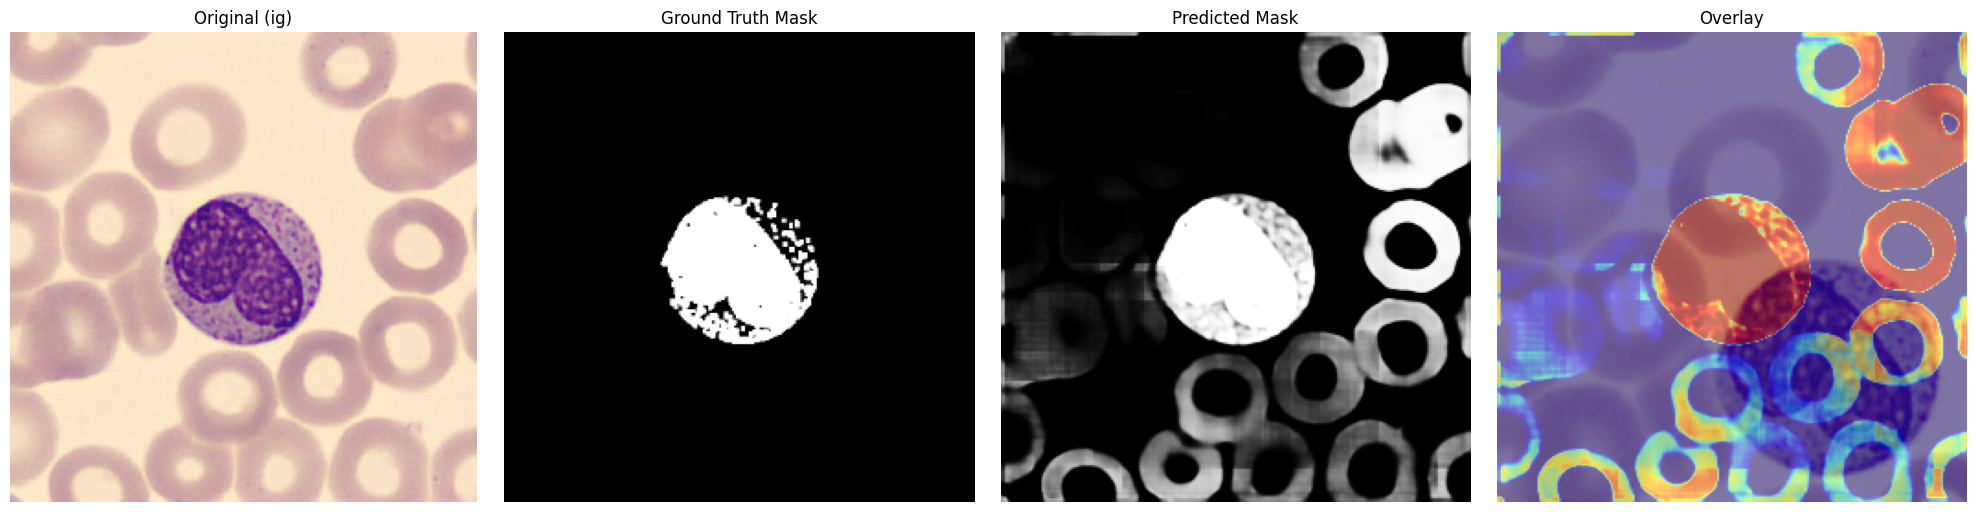

    Visualization complete
  Image 2/5: neutrophil - BNE_416205.jpg
    Making prediction...
    Prediction complete
    Creating visualization...


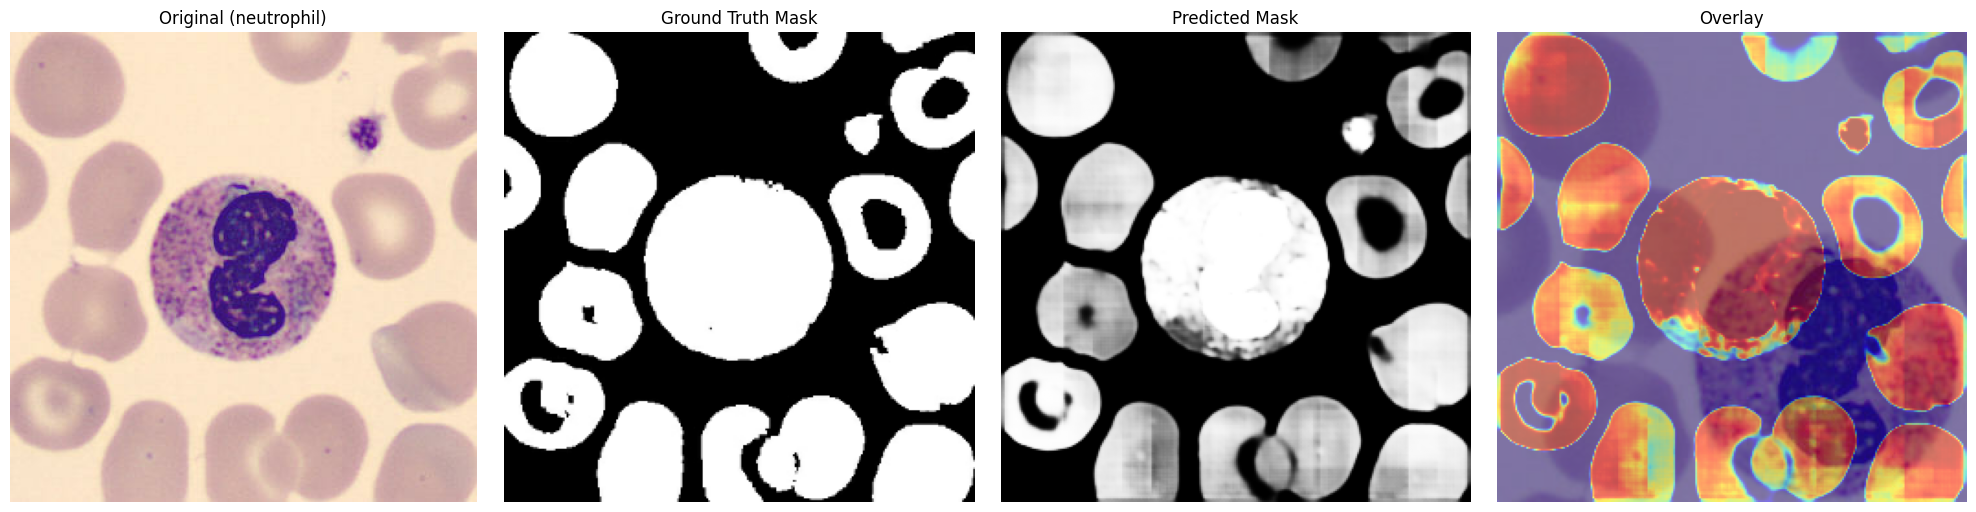

    Visualization complete
  Image 3/5: erythroblast - ERB_379497.jpg
    Making prediction...
    Prediction complete
    Creating visualization...


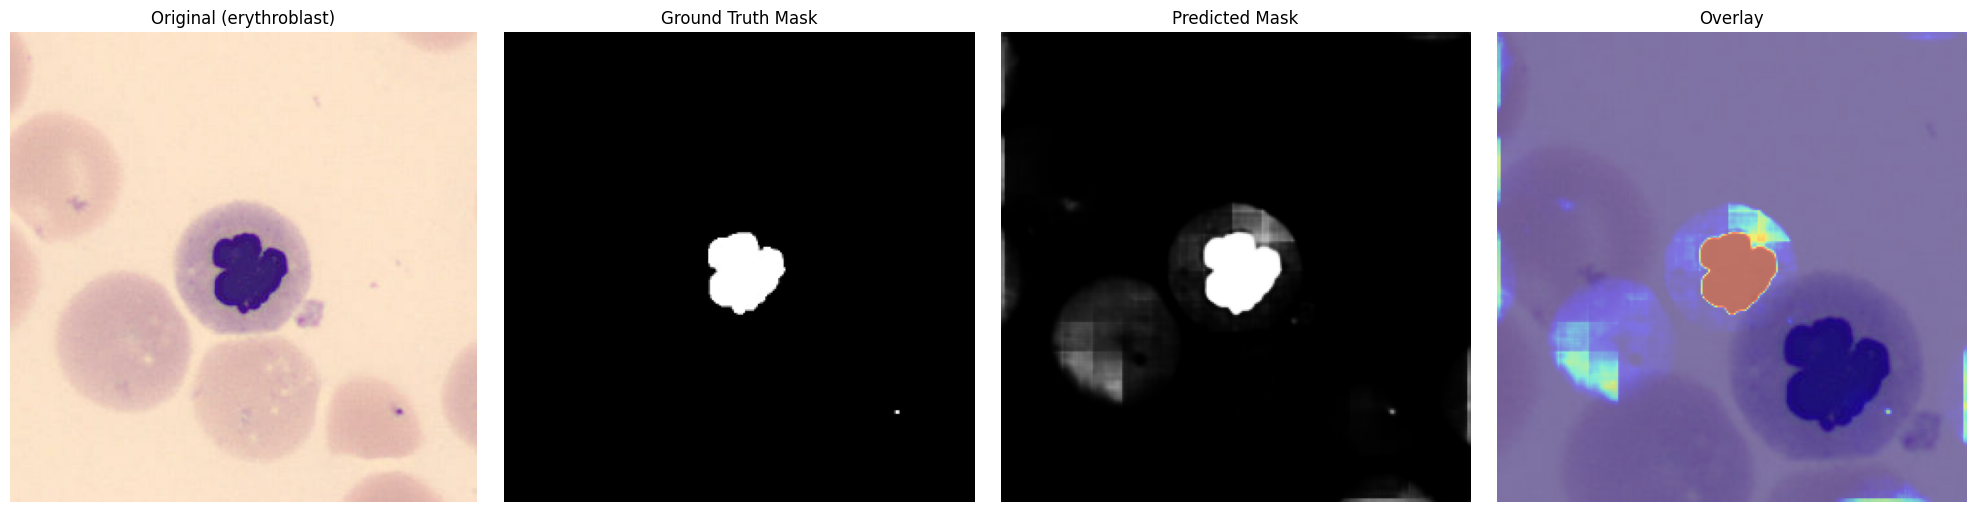

    Visualization complete
  Image 4/5: lymphocyte - LY_527440.jpg
    Making prediction...
    Prediction complete
    Creating visualization...


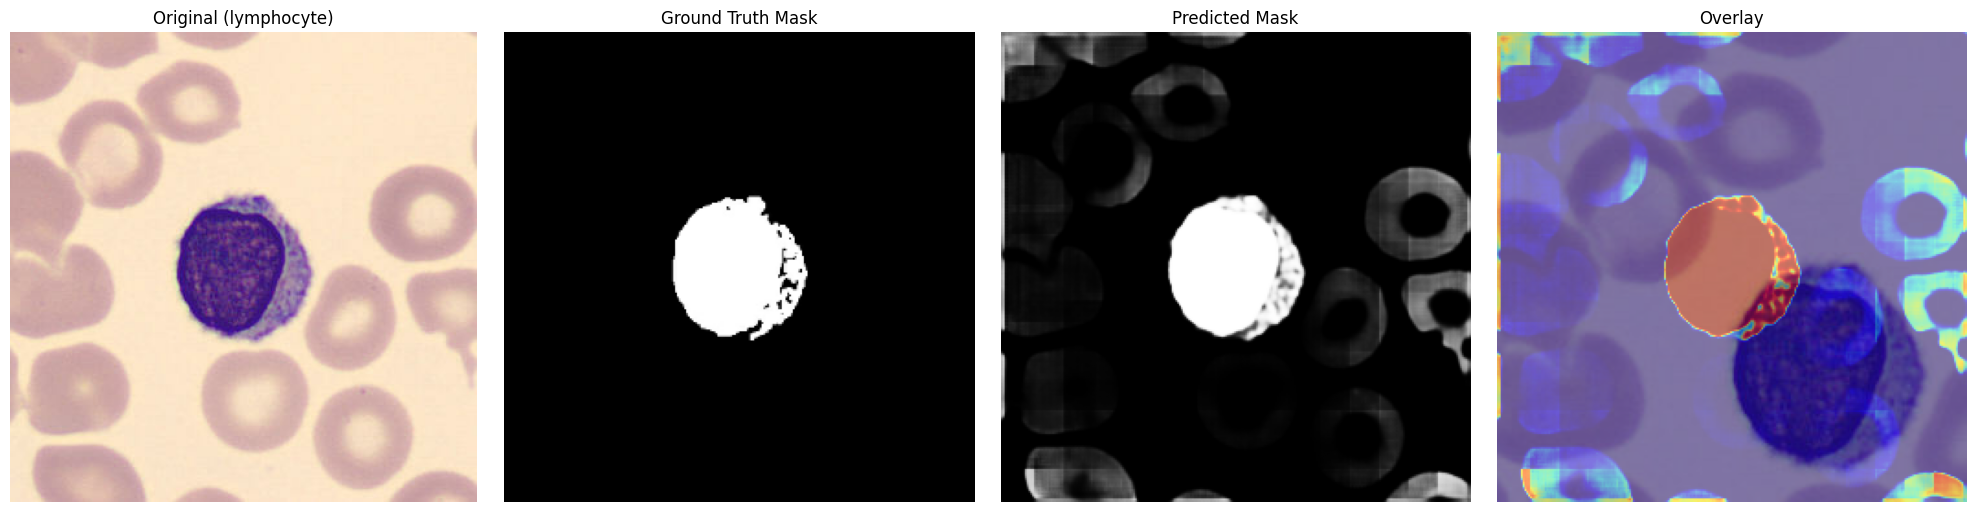

    Visualization complete
  Image 5/5: basophil - BA_992703.jpg
    Making prediction...
    Prediction complete
    Creating visualization...


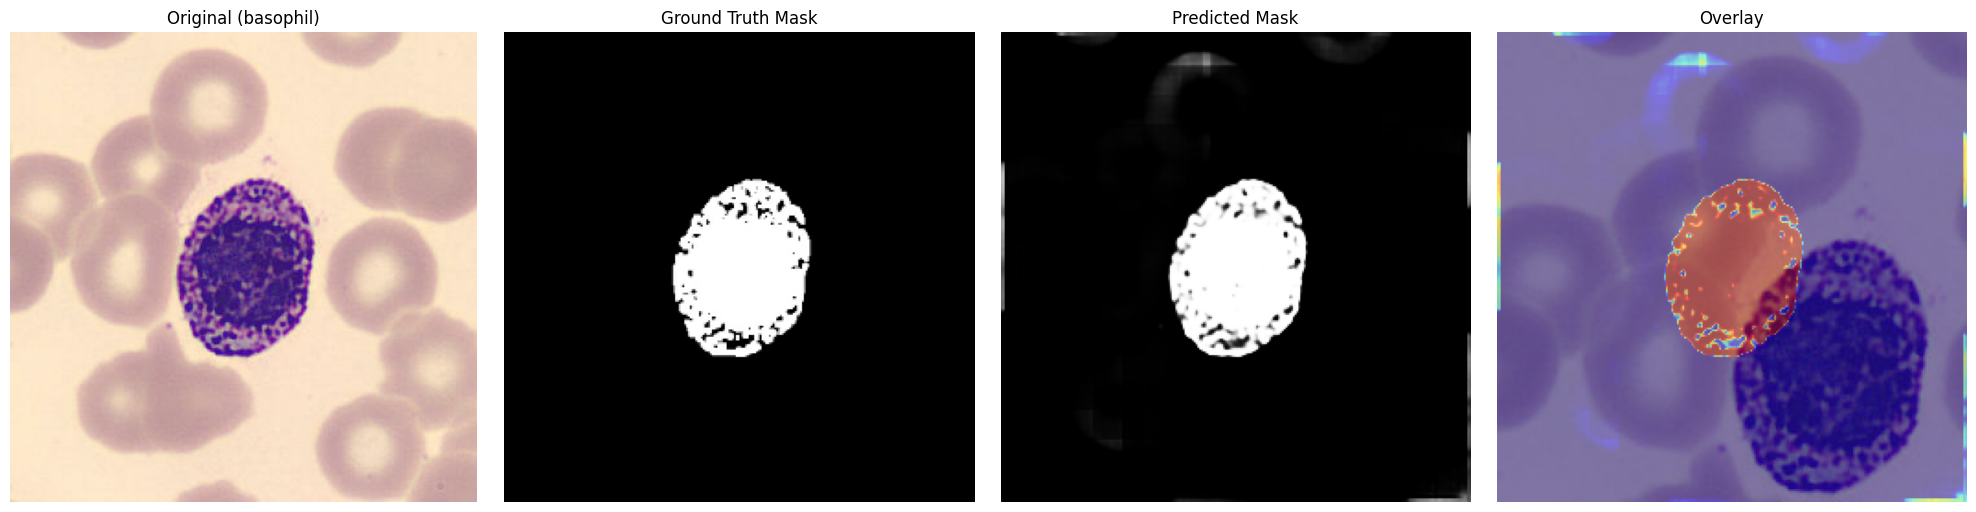

    Visualization complete


In [ ]:
# Test the trained model with better diagnostics
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import os
import time

def test_model_on_samples(model_path, num_samples=5):
    """Test the model on some sample images with detailed diagnostics."""
    print(f"Step 1: Checking if model exists at {model_path}")
    if not os.path.exists(model_path):
        print(f"ERROR: Model file not found at {model_path}")
        return
    else:
        print(f"✓ Model file found. Size: {os.path.getsize(model_path)/1024/1024:.1f} MB")

    # Define the IoU metric to load the model properly
    def iou_metric(y_true, y_pred):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
        iou = tf.reduce_mean((intersection + 1e-6) / (union + 1e-6))
        return iou

    # Load model
    print(f"Step 2: Loading model (this may take 20-30 seconds)...")
    start_time = time.time()
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'iou_metric': iou_metric},
            compile=False
        )
        print(f"✓ Model loaded successfully in {time.time() - start_time:.1f} seconds!")
    except Exception as e:
        print(f"ERROR loading model: {e}")
        return

    # Get cell types
    cell_types = ["basophil", "eosinophil", "erythroblast", "ig",
                 "lymphocyte", "monocyte", "neutrophil", "platelet"]

    print(f"Step 3: Looking for test images...")
    # Get random images from each cell type
    test_images = []
    for cell_type in cell_types:
        image_dir = f"/content/data/bloodcells_dataset/{cell_type}"
        if os.path.exists(image_dir):
            images = glob.glob(os.path.join(image_dir, "*.jpg"))
            if images:
                test_images.append(random.choice(images))
                print(f"  ✓ Found {len(images)} images for {cell_type}")
        else:
            print(f"  ✗ Directory not found: {image_dir}")

    if not test_images:
        print("ERROR: No test images found! Check your data directory paths.")
        return

    print(f"Step 4: Found {len(test_images)} test images total")

    # Randomly select up to num_samples
    if len(test_images) > num_samples:
        test_images = random.sample(test_images, num_samples)
        print(f"  Selected {num_samples} random images for testing")

    # Process each image
    print(f"Step 5: Processing images and generating predictions...")
    for i, img_path in enumerate(test_images):
        # Get cell type from path
        cell_type = os.path.basename(os.path.dirname(img_path))
        print(f"  Image {i+1}/{len(test_images)}: {cell_type} - {os.path.basename(img_path)}")

        # Load and preprocess image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        original_img = img.numpy()

        # Resize for model input
        img_resized = tf.image.resize(img, (256, 256))
        img_input = tf.cast(img_resized, tf.float32) / 255.0
        img_input = tf.expand_dims(img_input, 0)  # Add batch dimension

        # Predict mask
        print(f"    Making prediction...")
        pred_mask = model.predict(img_input, verbose=0)[0]
        print(f"    Prediction complete")

        # Get ground truth mask if available
        filename = os.path.basename(img_path)
        mask_path = f"/content/data/masks/{cell_type}/{filename}"

        print(f"    Creating visualization...")
        # Create figure
        if os.path.exists(mask_path):
            # With ground truth comparison
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            # Load ground truth mask
            gt_mask = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(gt_mask, channels=1)
            gt_mask = tf.image.resize(gt_mask, (256, 256))
            gt_mask = tf.cast(gt_mask, tf.float32) / 255.0

            # Plot original image
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original ({cell_type})")
            axes[0].axis("off")

            # Plot ground truth mask
            axes[1].imshow(gt_mask.numpy()[:, :, 0], cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            # Plot predicted mask
            axes[2].imshow(pred_mask[:, :, 0], cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            # Plot overlay
            axes[3].imshow(original_img)
            axes[3].imshow(pred_mask[:, :, 0], alpha=0.5, cmap="jet")
            axes[3].set_title("Overlay")
            axes[3].axis("off")
        else:
            # Without ground truth
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Plot original image
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original ({cell_type})")
            axes[0].axis("off")

            # Plot predicted mask
            axes[1].imshow(pred_mask[:, :, 0], cmap="gray")
            axes[1].set_title("Predicted Mask")
            axes[1].axis("off")

            # Plot overlay
            axes[2].imshow(original_img)
            axes[2].imshow(pred_mask[:, :, 0], alpha=0.5, cmap="jet")
            axes[2].set_title("Overlay")
            axes[2].axis("off")

        plt.tight_layout()
        plt.show()
        print(f"    Visualization complete")

# Test the model with detailed diagnostics
test_model_on_samples("/content/drive/MyDrive/cell_segmentation/models/unet-extended.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


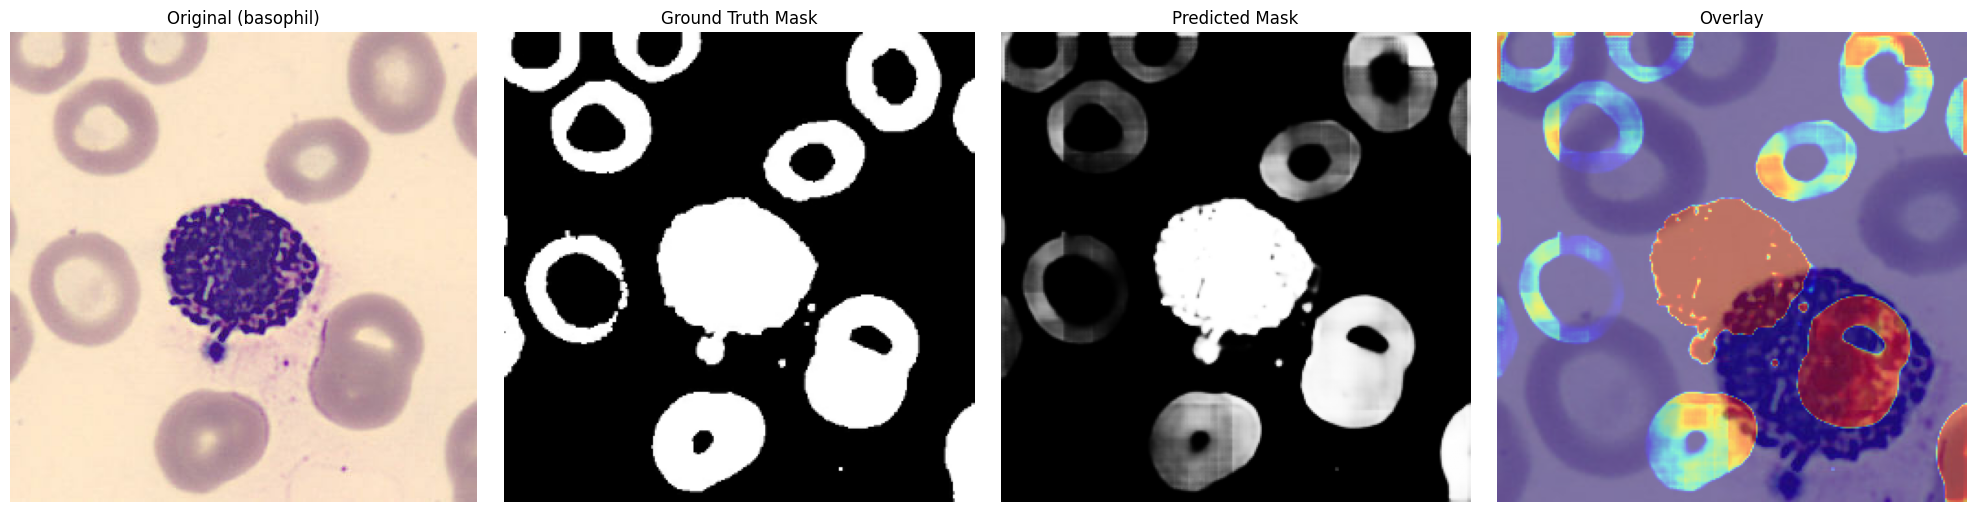

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


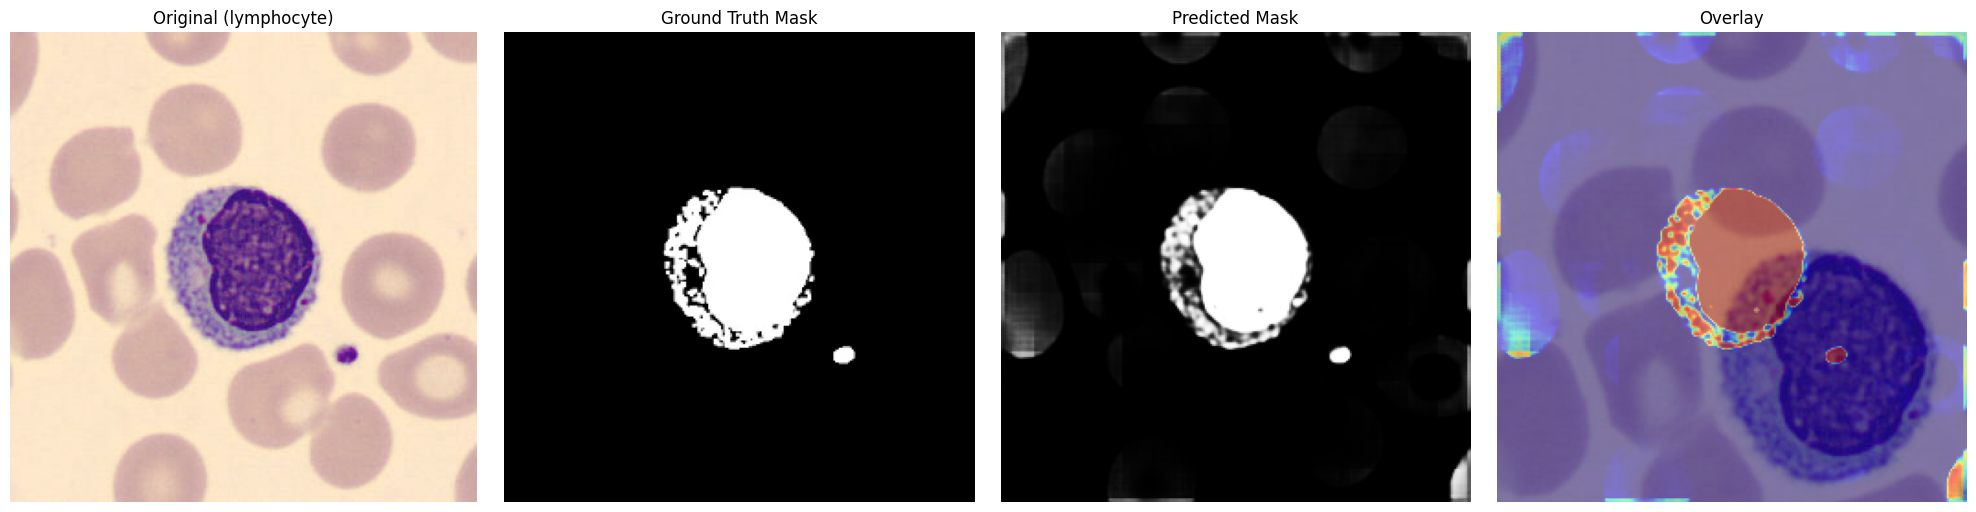

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


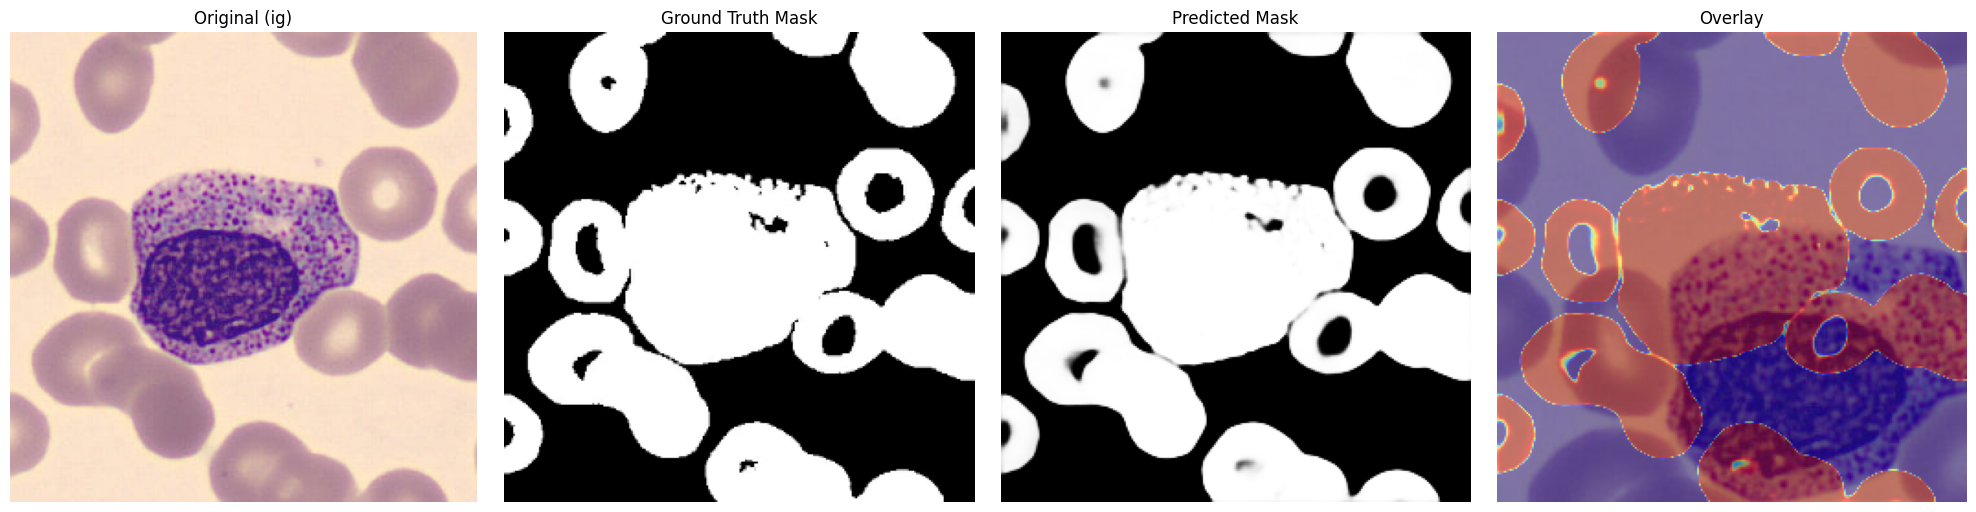

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


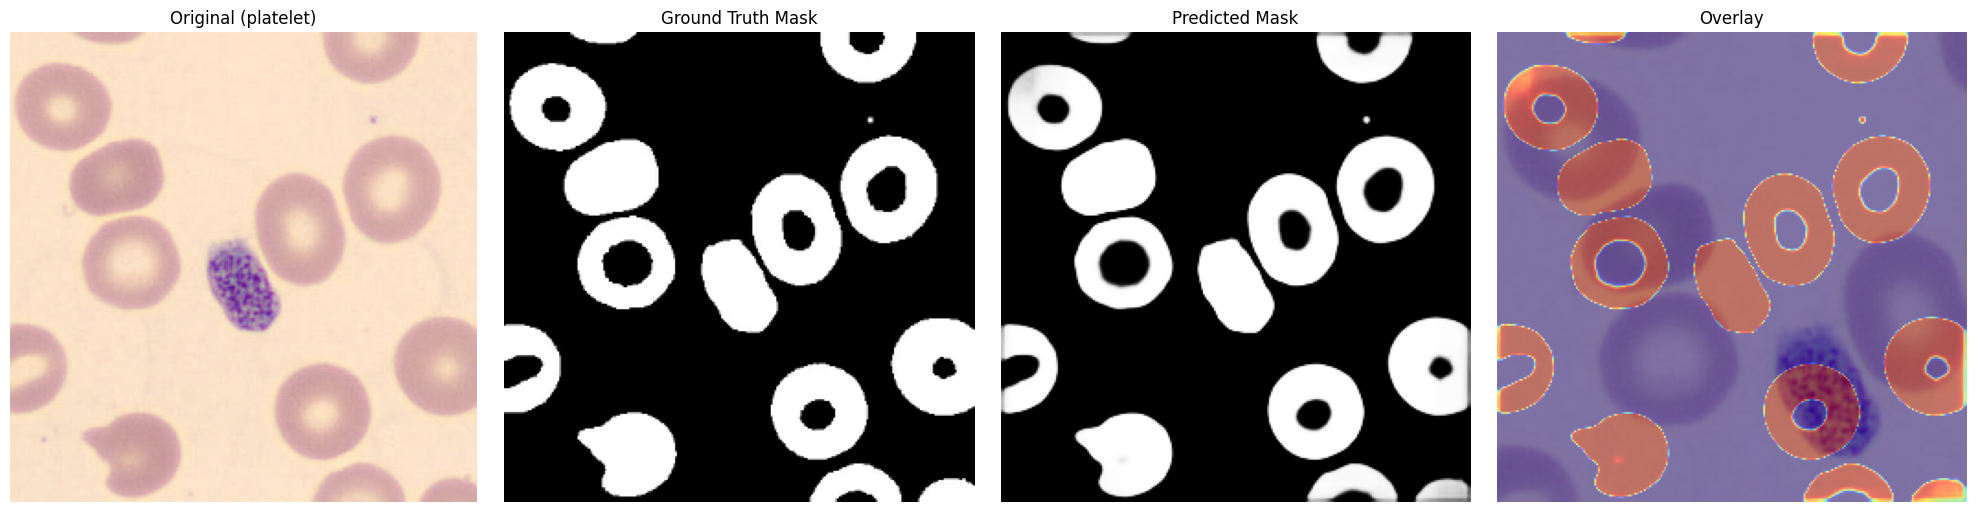

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


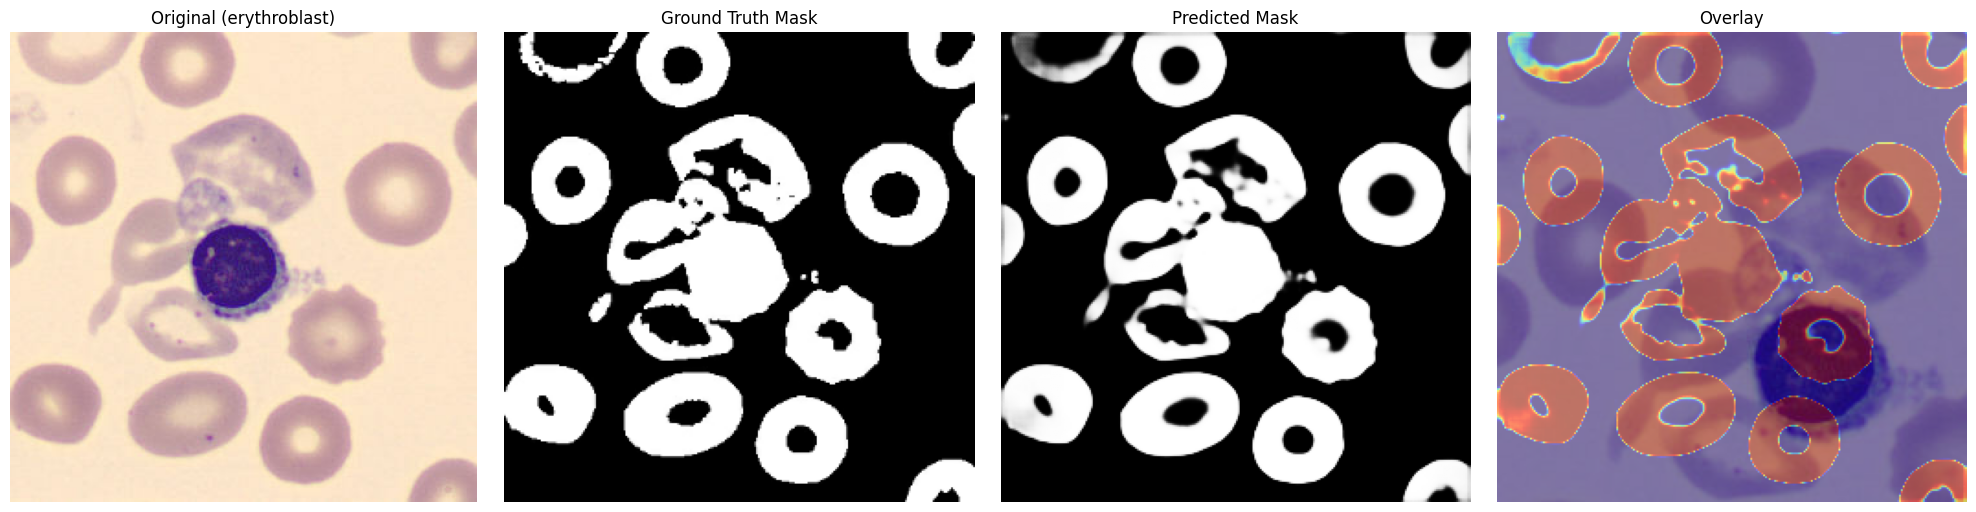

In [ ]:
# Test the trained model on some sample images
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import os

def test_model_on_samples(model_path, num_samples=5):
    """Test the model on some sample images."""
    # Load model
    model = tf.keras.models.load_model(model_path, compile=False)

    # Get cell types
    cell_types = ["basophil", "eosinophil", "erythroblast", "ig",
                 "lymphocyte", "monocyte", "neutrophil", "platelet"]

    # Get random images from each cell type
    test_images = []
    for cell_type in cell_types:
        image_dir = f"/content/data/bloodcells_dataset/{cell_type}"
        if os.path.exists(image_dir):
            images = glob.glob(os.path.join(image_dir, "*.jpg"))
            if images:
                test_images.append(random.choice(images))

    # Randomly select up to num_samples
    if len(test_images) > num_samples:
        test_images = random.sample(test_images, num_samples)

    # Process each image
    for img_path in test_images:
        # Get cell type from path
        cell_type = os.path.basename(os.path.dirname(img_path))

        # Load and preprocess image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        original_img = img.numpy()

        # Resize for model input
        img_resized = tf.image.resize(img, (256, 256))
        img_input = tf.cast(img_resized, tf.float32) / 255.0
        img_input = tf.expand_dims(img_input, 0)  # Add batch dimension

        # Predict mask
        pred_mask = model.predict(img_input)[0]

        # Get ground truth mask if available
        filename = os.path.basename(img_path)
        mask_path = f"/content/data/masks/{cell_type}/{filename}"

        # Create figure
        if os.path.exists(mask_path):
            # With ground truth comparison
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            # Load ground truth mask
            gt_mask = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(gt_mask, channels=1)
            gt_mask = tf.image.resize(gt_mask, (256, 256))
            gt_mask = tf.cast(gt_mask, tf.float32) / 255.0

            # Plot original image
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original ({cell_type})")
            axes[0].axis("off")

            # Plot ground truth mask
            axes[1].imshow(gt_mask.numpy()[:, :, 0], cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            # Plot predicted mask
            axes[2].imshow(pred_mask[:, :, 0], cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            # Plot overlay
            axes[3].imshow(original_img)
            axes[3].imshow(pred_mask[:, :, 0], alpha=0.5, cmap="jet")
            axes[3].set_title("Overlay")
            axes[3].axis("off")
        else:
            # Without ground truth
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Plot original image
            axes[0].imshow(original_img)
            axes[0].set_title(f"Original ({cell_type})")
            axes[0].axis("off")

            # Plot predicted mask
            axes[1].imshow(pred_mask[:, :, 0], cmap="gray")
            axes[1].set_title("Predicted Mask")
            axes[1].axis("off")

            # Plot overlay
            axes[2].imshow(original_img)
            axes[2].imshow(pred_mask[:, :, 0], alpha=0.5, cmap="jet")
            axes[2].set_title("Overlay")
            axes[2].axis("off")

        plt.tight_layout()
        plt.show()

# Test the model
test_model_on_samples("/content/drive/MyDrive/cell_segmentation/models/unet-extended.h5")

In [ ]:
# Download the trained model to your local machine
from google.colab import files
files.download('/content/drive/MyDrive/cell_segmentation/models/unet-extended.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Zip the results directory and download
!zip -r /content/results.zip /content/drive/MyDrive/cell_segmentation/models/
files.download('/content/results.zip')

  adding: content/drive/MyDrive/cell_segmentation/models/ (stored 0%)
  adding: content/drive/MyDrive/cell_segmentation/models/logs/ (stored 0%)
  adding: content/drive/MyDrive/cell_segmentation/models/logs/20250404-102849/ (stored 0%)
  adding: content/drive/MyDrive/cell_segmentation/models/logs/20250404-102849/train/ (stored 0%)
  adding: content/drive/MyDrive/cell_segmentation/models/logs/20250404-102849/train/events.out.tfevents.1743762529.5a9eea3d1438.8230.0.v2 (deflated 64%)
  adding: content/drive/MyDrive/cell_segmentation/models/logs/20250404-102849/validation/ (stored 0%)
  adding: content/drive/MyDrive/cell_segmentation/models/logs/20250404-102849/validation/events.out.tfevents.1743763345.5a9eea3d1438.8230.1.v2 (deflated 76%)
  adding: content/drive/MyDrive/cell_segmentation/models/model_best.h5 (deflated 6%)
  adding: content/drive/MyDrive/cell_segmentation/models/model_final.h5 (deflated 7%)
  adding: content/drive/MyDrive/cell_segmentation/models/training_history.png (defl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>